# Property price prediction

## Preparing libraries

In [10]:
import pandas as pd
import numpy as np
np.random.seed(0)

import qgrid
import missingno as msno

from sklearn.metrics import mean_absolute_error
from tqdm import tqdm 
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, cross_validate

import xgboost as xgb
import gc
import eli5
import mlflow

## Reading data

In [2]:
ls ../input/

big_train_warsaw_property.h5  train_data.h5@
test_warsaw_property.h5       train_warsaw_property.h5


In [14]:
df_train = pd.read_hdf("../input/train_warsaw_property.h5")
df_test = pd.read_hdf("../input/test_warsaw_property.h5")

df = pd.concat([df_train, df_test])
del df_train, df_test
gc.collect()

df.shape

(60222, 53)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60222 entries, 27731 to 92766
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           60222 non-null  int64  
 1   location                     60222 non-null  object 
 2   is_private                   60222 non-null  int8   
 3   piekarnik                    60222 non-null  bool   
 4   garaż                        60222 non-null  bool   
 5   monitoring / ochrona         60222 non-null  bool   
 6   rolety antywłamaniowe        60222 non-null  bool   
 7   kuchenka                     60222 non-null  bool   
 8   taras                        60222 non-null  bool   
 9   balkon                       60222 non-null  bool   
 10  ogródek                      60222 non-null  bool   
 11  dwupoziomowe                 60222 non-null  bool   
 12  system alarmowy              60222 non-null  bool   
 13  pom. użytkow

In [8]:
train.sample(5)

,id,location,is_private,piekarnik,garaż,monitoring / ochrona,rolety antywłamaniowe,kuchenka,taras,balkon,...,stan inwestycji,liczba kondygnacji,stan wykończenia,czynsz,rodzaj zabudowy,ogrzewanie,forma własności,stats,text,is_primary_market
79022,79022,"[pomorskie, Gdynia, Mały Kack, Druskiennicka]",0,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'ID': 98730848, 'visit_ads': '346', 'created_...",Opis Premiera Inwestycji Ruszyła przedsprzedaż...,True
15718,15718,"[lubelskie, Lublin, Wrotków]",0,False,False,True,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,pełna własność,"{'ID': 110616952, 'visit_ads': '390', 'created...",Opis Nowa inwestycja w okolicy Zalewu Zemborzy...,True
52972,52972,"[podlaskie, Białystok, Wysoki Stoczek, Dworska]",0,False,False,False,False,False,False,True,...,NaN,NaN,NaN,490 zł,blok,miejskie,pełna własność,"{'ID': 100970408, 'visit_ads': '616', 'created...",Opis Polecamy Państwu 3 pokojowe mieszkanie zl...,False
60235,60235,"[pomorskie, Gdynia, Witomino, Słoneczna]",-1,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,blok,NaN,NaN,"{'ID': 112553832, 'created_at': 'ponad 14 dni ...",Opis Słoneczna Zatoka to osiedle o zróżnicowan...,True
6597,6597,"[kujawsko-pomorskie, Bydgoszcz, Osiedle Leśne]",0,False,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,blok,miejskie,pełna własność,"{'ID': 112350576, 'visit_ads': '275', 'created...","Opis Mieszkanie 3-pokojowe o powierzchni 58,54...",False


## Helpers

In [17]:
def get_or_create_experiment(name):
    experiment = mlflow.get_experiment_by_name(name)
    if experiment is None:
        mlflow.create_experiment(name)
        return mlflow.get_experiment_by_name(name)
    
    return experiment

def _eid(name):
    return get_or_create_experiment(name).experiment_id

get_or_create_experiment("dwsolution_property")


def get_feats(df_fe, extra_black_list=[]):
    black_list = ["id", "price", "price_m2", "price_median"]
    black_list += extra_black_list
    
    return [x for x in df_fe.select_dtypes(["number", "boolean"]).columns if x not in black_list]

def get_X_y(df_fe, feats):
    train = df_fe[ df_fe["price"].notnull() ]
    test = df_fe[ df_fe["price"].isnull() ].copy()

    X_train = train[feats].values
    y_train = train["price"].values
    X_test =  test[feats].values

    print(X_train.shape, X_test.shape)
    return X_train, y_train, X_test, test


def quick_eli5(model, df_fe, feats=None, extra_black_list=[], top=30, save_filename=None):
    if feats is None:
        feats = get_feats(df_fe, extra_black_list)
        
    X_train, y_train, X_test, test = get_X_y(df_fe, feats)
    model.fit(X_train, y_train)
    
    if save_filename:
        test["price"] = model.predict(X_test)
        test[ ['id', 'price'] ].to_csv('../output/{}.csv'.format(save_filename), index=False) 
        
    return eli5.show_weights(model, feature_names=feats, top=top)

## Feature engineering

In [18]:
def feature_engineering(df):

    df["area_num"] = df["area"].map(lambda x: x.split("m")[0].replace(" ", "").replace(",", ".")).astype("float")
    df["area_num_log"] = np.log(df["area_num"])
    area_num_99 = np.percentile(df["area_num"], 99)
    df["area_norm"] = df["area_num"].map(lambda x: x if x <= area_num_99 else area_num_99  )
    df["area_per_room"] = df["area_norm"] / df["rooms"]
        
    df["price_m2"] = df["price"] / df["area_num"]

    
    for i in range(5):
        df["loc{}".format(i)] = df["location"].map(lambda x: x[i] if len(x) > i else "")

    df['loc01'] = df['loc0'] + df['loc1']
    df['loc012'] = df['loc0'] + df['loc1'] + df['loc2']
    df['loc12'] = df['loc1'] + df['loc2']
    
    df_val_cnts = df["loc12"].value_counts()
    loc12_vals = set(df_val_cnts[ df_val_cnts > 100 ].index.values)

    for item in loc12_vals:
        df[item] = df["loc12"] == item
        
    
    agg_funcs = ["median"]
    for grp_feat in ["price", "price_m2"]:
        for loc_num in ["loc0", "loc1", "loc2"]:
            loc_grp = df[ [grp_feat, loc_num] ].groupby(loc_num).agg(agg_funcs).to_dict()
            for agg_func in agg_funcs:
                df["{0}_{1}_{2}".format(loc_num, grp_feat, agg_func)] = df[loc_num].map(loc_grp[ (grp_feat, agg_func) ])

                
    df["price_loc1_median"] = df["area_norm"] * df["loc1_price_m2_median"]
                    
    floors_dict = {"parter": 0, "> 10": 11, "poddasze": -2, "suterena": -1 }
    df["floor_num"] = df["floor"].map(lambda x: floors_dict.get(x, x)).fillna(-10).astype("int")
    
    df["floors_in_building_num"] = df["floors_in_building"].map(lambda x: str(x).split("z")[-1].replace(")", "") if str(x) != "nan" else -1).astype("float")
    df["floors_in_building_num_norm"] = df["floors_in_building_num"].map(lambda x: x if x < 20 else 25)

    #start build year
    df["build_year"] = df["rok budowy"].fillna(-1).astype("int")
    years = [1970, 1980, 1990, 2000, 2005, 2010, 2012, 2014, 2016, 2017]
    for idx in range(len(years) - 1):
        df["build_year_{0}-{1}".format(years[idx], years[idx+1])] = (df["build_year"] >= years[idx]) & (df["build_year"] < years[idx+1])
    
    df["build_year_before_1970"] = df["build_year"] < 1970
    df["build_year_after_2017"] = df["build_year"] > 2017

    def build_year_norm(year):
        if year < 1970: return 1900
        if year > 2017: return 2018

        for idx in range(len(years) - 1):
            if year >= years[idx] and year < years[idx+1]:
                return years[idx]

    df["build_year_norm"] = df["build_year"].map(build_year_norm)
    #end build year
    
    df["rental"] = df["czynsz"].map(lambda x: str(x).split("zł")[0].replace(" ", "").replace(",", ".") if str(x) != "nan" else -1 )
    df["rental"] = df["rental"].map(lambda x: float(str(x).replace("eur", "") * 4) if "eur" in str(x) else x).astype("float")


    df['security'] = df['system alarmowy'] | df['rolety antywłamaniowe'] | df['drzwi / okna antywłamaniowe']
    

    big_cities = {'Poznań', 'Sopot', 'Wrocław', 'Kraków', 'Gdańsk', 'Gdynia', 'Opole', 'Katowice',  'Częstochowa', 'Szczecin', 'Kalisz', 'Łódź', 'Olsztyn', 'Warszawa'}
    for city in big_cities:
        df[city] = df["loc1"] == city
        df["big_city"] = df["loc1"].map(lambda x: x in big_cities)


    #categorical
    cat_feats = {
        "materiał budynku": "build_material_cat",
        "okna": "window_cat",
        "stan wykończenia": "property_completion_cat",
        "rodzaj zabudowy": "property_type_cat",
        "ogrzewanie": "property_heating_cat",
        "forma własności": "own_property_cat"
    }
    
    for feat_name, feat_new_name in cat_feats.items():
        df[feat_new_name] = df[feat_name].factorize()[0]
        
        #ohe
        df_dummies = pd.get_dummies(df[feat_name])
        df_dummies.columns = ["{0}_{1}".format(feat_new_name, x) for x in df_dummies.columns]
        df = pd.concat( [df, df_dummies], axis=1)
    
    return df
   

In [19]:
df_fe = feature_engineering(df.copy())

## Labs

In [20]:
df_fe['loc12_rooms'] = df_fe['loc12'] + df_fe['rooms'].map(lambda x: str(x) if x < 5 else "5")
df_fe['loc1_rooms'] = df_fe['loc1'] + df_fe['rooms'].map(lambda x: str(x) if x < 5 else "5")


df_train = df_fe[ df_fe["price"].notnull() ]
price_loc0 = df_train.groupby("loc0")["price"].agg(["mean", "median"])
price_m2_loc0 = df_train.groupby("loc0")["price_m2"].agg(["mean", "median"])

price_loc1 = df_train.groupby("loc1")["price"].agg(["mean", "median"])
price_m2_loc1 = df_train.groupby("loc1")["price_m2"].agg(["mean", "median"])

price_loc12 = df_train.groupby("loc12")["price"].agg(["mean", "median"])
price_m2_loc12 = df_train.groupby("loc12")["price_m2"].agg(["mean", "median"])

price_loc12_rooms = df_train.groupby("loc12_rooms")["price"].agg(["mean", "median"])
price_m2_loc12_rooms = df_train.groupby("loc12_rooms")["price_m2"].agg(["mean", "median"])


# df_fe["price_m2_loc1_median"] = df_fe["loc12_rooms"].map(lambda x: price_m2_loc1["median"].get(x) )


# df_fe["price_loc1_median"] = df_fe["loc1"].map(lambda x: price_loc1["median"].get(x) )
# df_fe["predict_price_loc1_median"] = df_fe["area_norm"] * df_fe["loc1"].map(lambda x: price_m2_loc1["median"].get(x) )

In [11]:
qgrid.show_grid(train, show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

<AxesSubplot:>

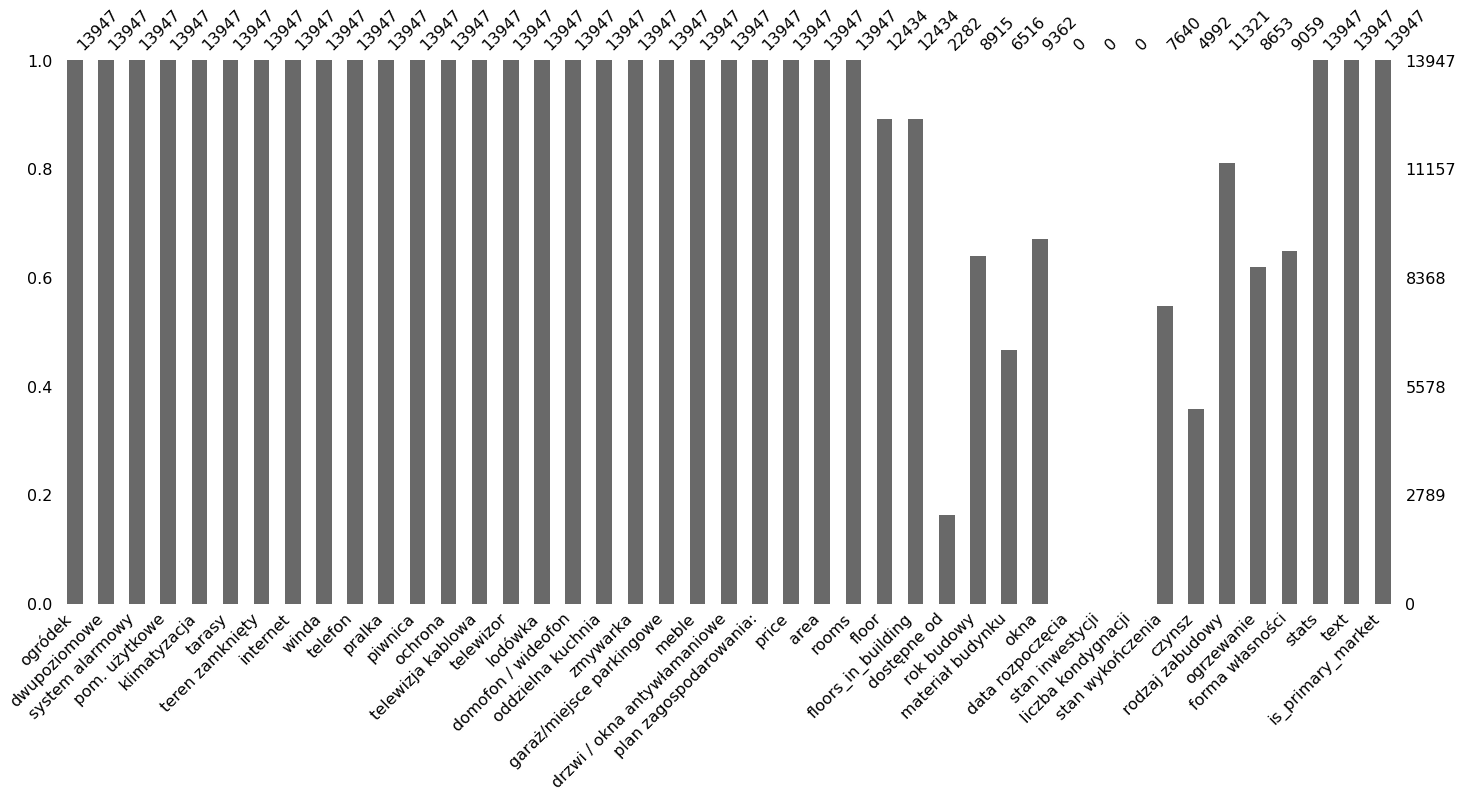

In [9]:
msno.bar(train.iloc[:,10:60])

<AxesSubplot:>

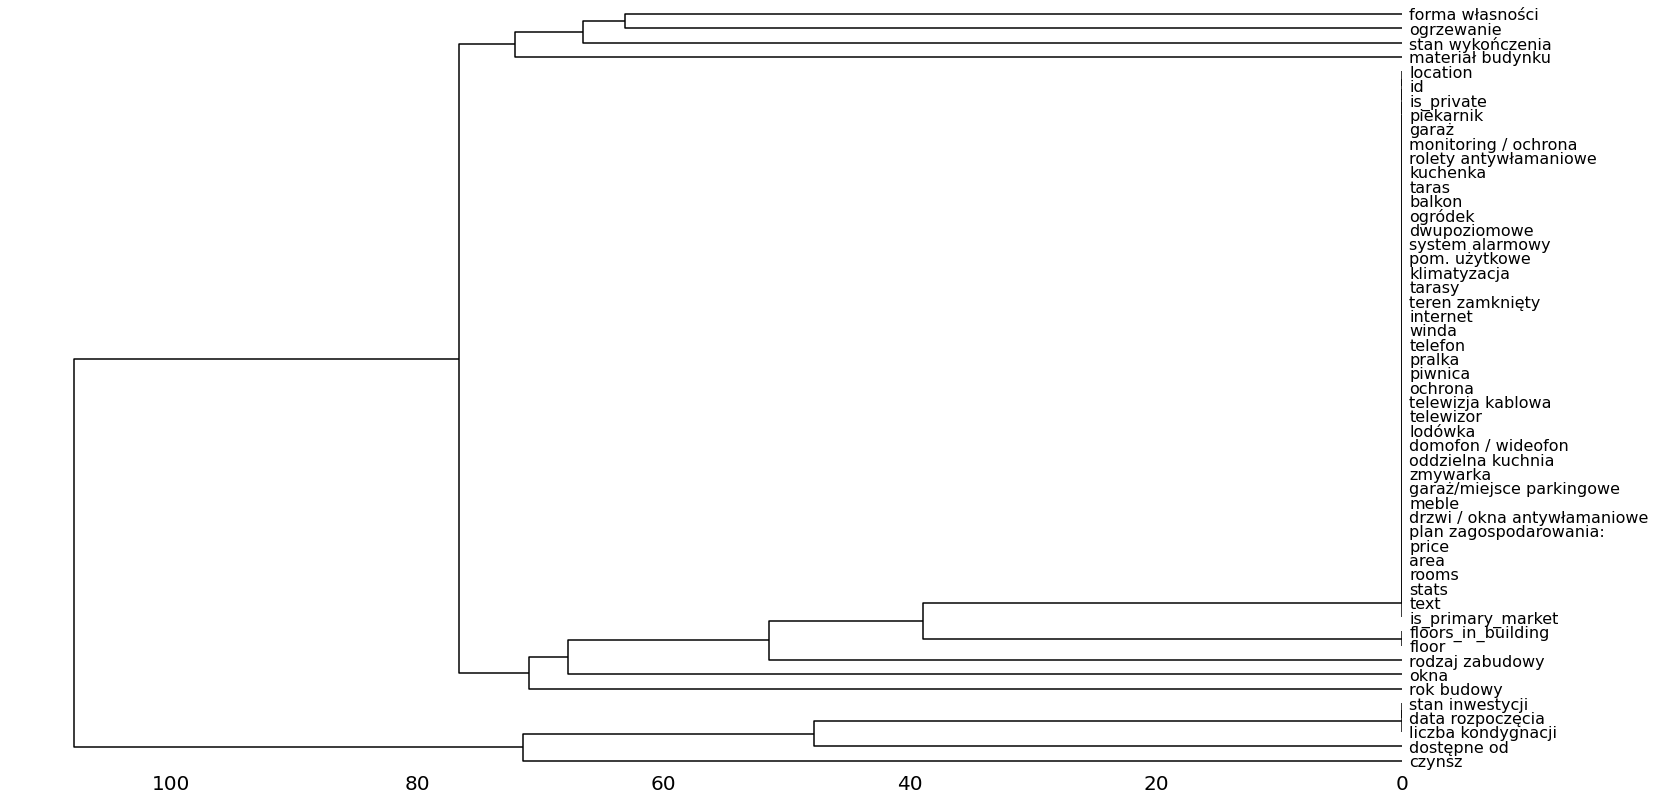

In [10]:
msno.dendrogram(train)

## Preparing model

In [21]:
black_list = ["property_type_cat_plomba", "garaż", "area_norm", "price_m2_norm", "property_heating_cat_elektryczne", "floors_in_building_num_norm", "ochrona", "property_completion_cat_do remontu", "window_cat_aluminiowe", "tarasy", "area_num_log", "build_material_cat_keramzyt", "build_material_cat_drewno", "build_material_cat_beton", "own_property_cat_udział"]

model = xgb.XGBRegressor(max_depth=8, n_estimators=150, random_state=0)
quick_eli5(model, df_fe, top=100, save_filename="v2_orig", extra_black_list=black_list)

(13947, 235) (46275, 235)


Weight,Feature
0.2306,price_loc1_median
0.1056,WarszawaŚródmieście
0.0562,GdyniaOrłowo
0.0375,area_num
0.0282,build_year_2014-2016
0.0251,loc2_price_m2_median
0.0202,KrakówWola Justowska
0.0149,loc2_price_median
0.0135,property_type_cat_apartamentowiec
0.0133,WarszawaWilanów
